 # Exercices de découverte du SNDS *(Version Python)*

 Bienvenue sur ce notebook d'introduction à la manipulation du SNDS ! L'objectif est de vous accompagner, grâce à une manipulation guidée, dans la découverte de quelques tables majeures du SNDS. Ces quelques exercices sont conçus pour vous donner une première prise en main des données disponibles et de leur structure, en attendant que vous ayez accès aux données réelles dont vous avez besoin pour vos projets.

 Nous allons ici constituer une cohorte de patients répondant à des critères particuliers, et nous intéresser à leur consommation de soins de ville (grâce au DCIR) et à l'hôpital (grâce au PMSI) au fil des différents exercices.

**A noter que les données utilisées pour le développement de ce notebook sont des données synthétiques avec les mêmes formats et types des valeurs des données réelles du SNDS. Il s'agit de données fictives générées aléatoirement, qui ne sont pas nécessairement plausibles et ne recouvrent pas une réalité médicale. Ces données ont été générées par le Lab Santé de la DREES.**

Pour plus d'information sur ces données, vous pouvez consulter la [page dédiée sur le site de documentation du SNDS](https://documentation-snds.health-data-hub.fr/ressources/donnees_synthetiques.html#ou-trouver-le-snds-synthetique).

 ## Préparation et configuration

 Commençons par préparer le terrain. Nous utiliserons dans les exercices un certain nombre de modules (désignation des bibliothèques/packages en Python) pour nous faciliter la tâche. Vous devrez ainsi avoir installé les modules suivants pour exécuter le code : **numpy**, **pandas** et **seaborn** (voir le code pour les détails).

In [1]:
# Chargement des modules et paramètres globaux
import numpy as np                  # Calcul scientifique

import pandas as pd                 # Manipulation de données

import seaborn as sns               # Visualisation de données

import os.path                      # Opérations sur chemins de fichiers

 Nous allons également définir des variables de configuration, qui serviront à indiquer où sont stockés les différents fichiers de données, ici les tables du SNDS que nous utilisons. Il peut être nécessaire de télécharger ces fichiers de données dans l’environnement local.

In [2]:
# Chemins d'accès aux fichiers
DATA_DIR = os.path.abspath("../data/")              # Dossier où sont stockées les données

ER_PRS_F_FILE = os.path.join(DATA_DIR, "ER_PRS_F.csv")      # Table des prestations
ER_PHA_F_FILE = os.path.join(DATA_DIR, "ER_PHA_F.csv")      # Table de la pharmacie
T_MCO_C_FILE = os.path.join(DATA_DIR, "T_MCOaa_nnC.csv")    # MCO - Pseudonymes des patients et dates de soin
T_MCO_B_FILE = os.path.join(DATA_DIR, "T_MCOaa_nnB.csv")    # MCO - Description du séjour

In [ ]:
# Récupération des fichiers de données depuis Gitlab
# Cette étape est optionnelle si les données sont déjà présentes (par exemple si vous avez cloné tout le dossier Gitlab)

import urllib.request               # Téléchargement de fichiers

GITLAB_DATA_URL = "https://gitlab.com/healthdatahub/formation/exercices-snds/-/raw/master/data/"

urllib.request.urlretrieve(GITLAB_DATA_URL + "ER_PRS_F.csv", ER_PRS_F_FILE)
urllib.request.urlretrieve(GITLAB_DATA_URL + "ER_PHA_F.csv", ER_PHA_F_FILE)
urllib.request.urlretrieve(GITLAB_DATA_URL + "T_MCOaa_nnC.csv", T_MCO_C_FILE)
urllib.request.urlretrieve(GITLAB_DATA_URL + "T_MCOaa_nnB.csv", T_MCO_B_FILE)

 Pour rendre les exercices plus intéressants et pour suivre notre cohorte dans les différentes tables, nous allons avoir besoin de faire des jointures entre les tables du SNDS. Le DCIR, qui regroupe les informations sur les soins de ville, est composé de différentes tables, que l'on joint en utilisant 9 clefs de jointure (`FLX_DIS_DTD`, `FLX_TRT_DTD`, `FLX_EMT_TYP`, `FLX_EMT_NUM`, `FLX_EMT_ORD`, `ORG_CLE_NUM`, `DCT_ORD_NUM`, `PRS_ORD_NUM`, `REM_TYP_AFF`). Le PMSI, qui regroupe les informations sur les soins à l'hôpital, a ses propres clefs de jointure entre tables, au nombre de deux (`ETA_NUM` et `RSA_NUM`). La signification de chacune de ces clefs n'a pas d'importance ici ; nous avons simplement besoin de les lire pour faire les jointures à l'avenir.
 
 
Pour plus d'informations sur les clés de jointure, vous pouvez-vous vous reporter à la [documentation des tables du SNDS](https://documentation-snds.health-data-hub.fr/tables/).

In [4]:
# Définition des variables de jointure
DCIR_join_vars = [          # Variables de jointure du DCIR
    "FLX_DIS_DTD",
    "FLX_TRT_DTD",
    "FLX_EMT_TYP",
    "FLX_EMT_NUM",
    "FLX_EMT_ORD",
    "ORG_CLE_NUM",
    "DCT_ORD_NUM",
    "PRS_ORD_NUM",
    "REM_TYP_AFF"
]

MCO_join_vars = [           # Variables de jointure du PMSI/MCO
    "ETA_NUM",
    "RSA_NUM"
]

 ## Exercice 1 : Constitution d'une cohorte

 Nous pouvons désormais passer au premier exercice : la constitution d'une cohorte de patients que nous allons suivre dans leur consommation de soins. Plus précisément, nous allons constituer une cohorte de patientes (de sexe féminin donc), ayant consulté un oncologue et âgées de 40 à 70 ans au moment de la consultation.

 Les informations concernant les patients (sexe, l'âge au moment du soin, etc) et les prestations sont regroupées dans la table des prestations **ER_PRS_F** (PRS = prestations). Nous allons donc naturellement définir un ensemble de filtres à appliquer à cette table pour sélectionner les patients répondant aux critères d'inclusion, puis cibler les pseudonymes de ces patients pour constituer notre cohorte.

In [5]:
# On récupère les données des prestations, cette table comprend également les données des bénéficiaires
df_presta = pd.read_csv(
    ER_PRS_F_FILE,                      # Chemin vers le fichier
    usecols=[
        "BEN_NIR_PSA",                  # Pseudonyme du bénéficiaire
        "BEN_AMA_COD",                  # Age au moment de la prestation
        "BEN_SEX_COD",                  # Code sexe
        "PSE_SPE_COD",                  # Spécialité médicale du Professionnel de Santé exécutant
        "PSP_SPE_COD",                  # Spécialité médicale du Professionnel de Santé prescripteur
        "PRS_NAT_REF",                  # Nature de la prestation de référence
        "EXE_SOI_DTD"                   # Date d'exécution du soin
    ] + DCIR_join_vars,                 # Variables de jointure du DCIR
    header=0,
    sep=","
)
df_presta.set_index(DCIR_join_vars, inplace=True)

Afin d'en apprendre plus sur ces variables, nous vous invitons à consulter la documentation de la table [ER_PRS_F](https://documentation-snds.health-data-hub.fr/tables/ER_PRS_F/).

Pour comprendre les modalités des variables `PSE_SPE_COD`, `PSP_SPE_COD` et `PRS_NAT_REF`, référez-vous respectivement aux nomenclatures **IR_SPE_V** et **IR_NAT_V** disponibles dans le [dictionnaire intéractif du SNDS](http://dico-snds.health-data-hub.fr).

In [6]:
# On sélectionne les prestations ...
filtres_presta_ex1 = (
    (df_presta["BEN_SEX_COD"] == 2)                 # ... pour des femmes
    & (df_presta["BEN_AMA_COD"] >= 40)              # ... de plus de 40 ans
    & (df_presta["BEN_AMA_COD"] <= 70)              # ... de moins de 70 ans
    & (
        (df_presta["PSE_SPE_COD"] == 73) | (df_presta["PSE_SPE_COD"] == 74) |   # Exécutées par un oncologue
        (df_presta["PSP_SPE_COD"] == 73) | (df_presta["PSP_SPE_COD"] == 74)     # Prescrits par un oncologue
    )
)

Les patients sont identifiés grâce aux variables `BEN_NIR_PSA` - éventuellement couplée au rang gémellaire `BEN_RNG_GEM` - ou `BEN_NIR_ANO` lorsque renseignée. Pour en apprendre plus sur l'identification des bénéficiaires, reportez-vous à la fiche [Identifiants des bénéficiaires](https://documentation-snds.health-data-hub.fr/fiches/fiche_beneficiaire.html#identifiants-des-beneficiaires).

In [7]:
# NB: On ne prend pas en compte le rang gémellaire "BEN_RNG_GEM"...
#... qui permet de s'assurer que la cohorte correspond bien à des personnes uniques
cohorte_liste = list(
    set(df_presta[filtres_presta_ex1]["BEN_NIR_PSA"])
)

print("Liste de pseudonymes de la cohorte de patients :\n\n", cohorte_liste)

Liste de pseudonymes de la cohorte de patients :

 ['xSeDMVWEgWvFziIoU', 'PTsMvCrqnbbzVfICf', 'QzaQOchjGYjLlzRyo', 'XMGpQyXHWVyaxecnP', 'qXozgqqRghsXsrkqc', 'eSUCzdeQXsLaxxehx', 'QALnStWbPBwHWlwZN', 'mptTUzhJfrgjcOLfk', 'DWwkvOppYHctPjKvn', 'UDpxAZZjwGJIegsSq', 'uyfWTDJLIJjsjrxEX', 'QnHNTortYhPNWdKTy', 'hbZDiDcyyQScsaMOW', 'TwfCAbcTwtlPAxvMh', 'ITDPTwOrhRToVNXwv', 'IgunKBglVOVNmmNpj', 'nrnnXxGboLpgNQItQ', 'iLnZOwOZuZoRxVExe', 'afvJpaNsLQTLWzyzF', 'kScUEObiosYGYbGbm', 'WNYxMtPkRpPKkYFGN', 'rWnTFphjsSqBRmhor', 'gUxVVskvxRjUXaPdd']


## Exercice 2 : Top médicament

 Nous allons maintenant nous intéresser aux médicaments prescrits en soins de ville à nos patientes. Plus précisément, nous allons déterminer le médicament ayant été remboursé (au moins une fois, quelle que soit la quantité) au plus grand nombre de patientes différentes de la cohorte.

 Les informations concernant le remboursement de médicaments sont regroupées dans la table affinée de pharmacie **ER_PHA_F** (PHA = Pharmacie de ville), regroupant une multitude de variables que nous ne traiterons pas ici. Afin d'en apprendre plus sur ces variables, nous vous invitons à consulter la documentation de la table [ER_PHA_F](https://documentation-snds.health-data-hub.fr/tables/ER_PHA_F/). 
 
 Nous allons nous intéresser au code CIP (Code Identifiant de Présentation) des médicaments, un code à 13 chiffres identifiant chaque médicament, encodé  dans la variable `PHA_PRS_C13`.

In [8]:
# On récupère les données de pharmacie
df_pharma = pd.read_csv(
    ER_PHA_F_FILE,                      # Chemin vers le fichier
    usecols=[
        "PHA_PRS_C13",                  # Code CIP de la pharmacie de ville
        "PHA_ACT_QSN"                   # Quantité de boites facturées
    ] + DCIR_join_vars,                 # Variables de jointure DCIR
    header=0,
    sep=","
)

 Le code CIP permet d’identifier un médicament précisément, c’est-à-dire sa molécule mais aussi son nom commercial, son laboratoire, son dosage, son conditionnement et son prix unitaire. Pour en apprendre plus sur le code CIP, vous pouvez lire la fiche [Cibler selon les médicaments](https://documentation-snds.health-data-hub.fr/fiches/medicament.html#identification-des-medicaments).

 Pour prendre connaissance de l'ensemble des codes CIP, référez-vous à la nomenclature **IR_PHA_R** disponible dans le [dictionnaire intéractif du SNDS](http://dico-snds.health-data-hub.fr).

In [9]:
# On ne regarde que les données de pharmacie qui concernent les patients dans
# la cohorte.
filtres_presta_ex2 = df_presta["BEN_NIR_PSA"].isin(cohorte_liste)
df_pharma_coh = df_pharma.join(df_presta[filtres_presta_ex2], on=DCIR_join_vars).dropna()

In [10]:
# Prise en compte de la régularisation des remboursements de médicaments prescrits (utile dans le SNDS réel)
# On somme sur chaque combinaison unique des variables identifiants un médicament donné
# pour une prestation donnée
df_pharma_summed = df_pharma_coh.groupby(["PHA_PRS_C13","EXE_SOI_DTD", "BEN_NIR_PSA"]).agg('sum')

# On ajoute une colonne "ID" représentant l'indice de la ligne
df_pharma_coh["ID"]=np.arange(len(df_pharma_coh))

# On joint ensuite la table initiale avec la table des sommes de quantité de boites facturées
df_pharma_coh.set_index(["PHA_PRS_C13", "EXE_SOI_DTD", "BEN_NIR_PSA"], inplace=True)
df_pharma_joined = df_pharma_summed.join(df_pharma_coh, on=["PHA_PRS_C13","EXE_SOI_DTD", "BEN_NIR_PSA"],
                                             lsuffix="_summed", rsuffix="_initial")

# On filtre en gardant uniquement les quantité de boites facturées positives et non nulle
index_list = df_pharma_joined[df_pharma_joined["PHA_ACT_QSN_summed"] > 0]["ID"]
df_pharma_cleaned = df_pharma_coh[df_pharma_coh["ID"].isin(list(index_list))]


Dans les tables de prestations il existe des lignes de régularisation. Elles annulent certaines prescriptions ou exécutions d’actes qui n’ont pas eu lieu (liquidés par erreur) ou les corrigent. Les lignes de régularisation sont en tout point identiques à la ligne initiale mais avec des quantités d'actes `PHA_ACT_QSN` qui leur sont propre. 

Il faut donc sommer les quantités `PHA_ACT_QSN` des lignes identiques - certaines lignes de régularisation ayant `PHA_ACT_QSN < 0` - pour ne conserver que les prescriptions ou exécutions d'actes ayant réellement été remboursés.

Pour en apprendre plus, vous pouvez lire les recommandations pour les requêtes dans la fiche [Requête type dans la table prestations du DCIR](https://documentation-snds.health-data-hub.fr/fiches/sas_prestation_dcir.html#recommandations-pour-les-requetes).

/!\ Attention, les données synthétiques ne limitent pas les données d'une table à une période temporelle donnée. Cela est toutefois le cas dans le SNDS. Les tables des prestations sont par exemple annuelles jusqu'à l'année d'archivage.

In [11]:
# On remet les bonnes informations en index pour préparer la jointure suivante
df_pharma_coh.reset_index(inplace=True)

# Pour chaque médicament, on calcule le nombre de patientes de la cohorte
# à qui il a été prescrit.
medicament_freq = (
    df_pharma_coh
        .groupby("PHA_PRS_C13")["BEN_NIR_PSA"]      # Groupage par code CIP
        .apply(lambda x: x.nunique())               # COUNT DISTINCT
)
# On sélectionne ensuite le médicament ayant été prescrit au plus grand nombre
# de patients.
top_medicament = medicament_freq.idxmax()

# NB : il peut y avoir plusieurs top médicaments ex aequo
print(
    top_medicament,
    "est l'un des médicaments ayant été prescrits au plus grand nombre de patients différents, soit",
    medicament_freq[top_medicament]
)

3400937722001 est l'un des médicaments ayant été prescrits au plus grand nombre de patients différents, soit 6


 ## Exercice 3 : Top prestations

 Changeons de point de vue pour ce nouvel exercice ! Laissons de côté notre cohorte un instant pour calculer le top 10 (ou n) des prestations réalisées par les oncologues au cours de l'année, pour les patients des deux sexes.

 Nous avons déjà toutes les données dont nous avons besoin dans la table des prestations (pour avoir le sexe des patients). On groupe ensuite les données par sexe, et on calcule le top 10 prestations pour chaque groupe, puis on affiche le résultat en histogramme en utilisant *seaborn*.

In [12]:
# On ne regarde ici que les prestations réalisées par des oncologues.

# On sélectionne les prestations ...
filtres_presta_ex3 = (
    (
        (df_presta["PSE_SPE_COD"] == 73)        # Exécutées par un oncologue
        | (df_presta["PSE_SPE_COD"] == 74))
)

df_presta_onco = df_presta[filtres_presta_ex3].copy()   # Données des prestations d'oncologues

Concernant les activités et consultations externes, se référer à l'exercice 1.

In [13]:
# Attribution de labels aux codes sexe
df_presta_onco["BEN_SEX_COD"] = df_presta_onco["BEN_SEX_COD"].map(
    {1: 'Masculin', 2: 'Feminin', 0: 'Inconnu', 9: 'Inconnu'}
)
# NB: Dans les données réelles du SNDS une 5e valeur est possible "" qui correspond à une donnée manquante

La variable `BEN_SEX_COD` pointe vers la nomenclature **IR_SEX_V**, qu'on peut retrouver dans le [dictionnaire intéractif du SNDS](http://dico-snds.health-data-hub.fr).

La distribution des sexes n'est pas respectée dans les données synthétiques. Ainsi, on a une majorité de sexe 'Inconnu'.

In [14]:
# On calcule, en fonction du sexe du patient, le nombre de prestations de
# chaque type réalisées par les oncologues au cours de l'année.
df_cnt_presta = (
    df_presta_onco["PRS_NAT_REF"]                       # Nature des prestations
        .groupby(df_presta_onco["BEN_SEX_COD"])         # Groupage par sexe
        .value_counts()                                 # Comptage pour chaque type
        .sort_values(ascending=False)                   # Tri décroiss. par compte
        .rename("count")
        .reset_index()
)

# On se limite au n_top_presta prestations les plus fréquentes pour chaque sexe
n_top_presta = 10
df_top_presta = (
    df_cnt_presta
        .groupby("BEN_SEX_COD")                     # Groupage par sexe
        .head(n_top_presta)                         # Top n lignes
        .reset_index()                              # Ajout d'une colonne "index"
)

La variable `PRS_NAT_REF` contient la nature de la prestation de référence (consultation, biologie, pharmacie). Si vous voulez un niveau de détail plus fin (quelle analyse de biologie, quel médicament....), il faut aller chercher les informations dans les tables affinées (**ER_PHA_F**, **ER_BIO_F**, ...).

C:\Users\RomainGirard\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


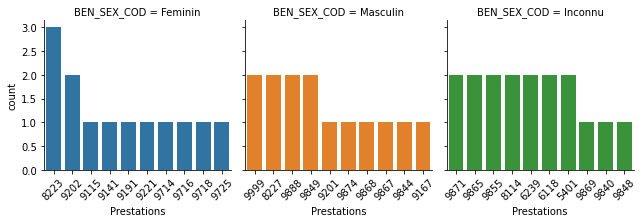

In [53]:
# On affiche les résultats sous forme d'histogramme
g = sns.FacetGrid(
    data=df_top_presta,
    hue="BEN_SEX_COD",                  # Couleur différente pour chaque sexe
    col="BEN_SEX_COD",                  # Une figure par sexe
    sharey=True,                        # Même échelle verticale
    sharex=False,                       # Échelles horizontales différentes
    margin_titles=True                  # Titres des figures
)
g.map(sns.barplot, "index", "count")
g.set(xlabel="Prestations")

# On itère sur les axes pour améliorer l'affichage des figures
xlabels=[]
for ax in g.axes.flat:
    idx_xticklabels = [int(l.get_text()) for l in ax.get_xticklabels()]
    prs_xticklabels = df_top_presta.loc[df_top_presta["index"].isin(idx_xticklabels), "PRS_NAT_REF"]
    ax.set_xticklabels(prs_xticklabels, rotation=45) # Rotation des labels à 45°

 ## Exercice 4 : Hospitalisation de longue durée

 Après ces quelques exercices sur le DCIR, il est temps de s'intéresser au PMSI. Plus précisément, nous allons constituer une sous-cohorte de patients : parmi les patientes de notre cohorte précédente, nous allons repérer celles dont les séjours sont les plus longs (durée de séjour dans le troisième quartile de l'ensemble des séjours à l'hôpital).

 Nous allons donc nous restreindre au champ MCO (Médecine-Chirurgie-Obstétrique) du PMSI. Les données qui nous intéressent ici sont regroupées dans la table **T_MCO_C**.

In [54]:
# On récupère les données du MCO qui concernent les pseudonymes des patients et les
# dates des séjours.
df_mco_c = pd.read_csv(
    T_MCO_C_FILE,                       # Chemin vers le fichier
    usecols=[
        "ENT_DAT",                      # Date d'entrée
        "SOR_DAT",                      # Date de sortie
        "NIR_ANO_17"                    # Pseudonyme du bénéficiaire
    ] + MCO_join_vars,                  # Variables de jointure MCO
    header=0,
    sep=",",
    dtype="object"                      # Pour éviter l'interprétation des dates en tant que nombres
)
df_mco_c.set_index(MCO_join_vars, inplace=True)

Vous trouverez le schéma du concept MCO et l'articulation de ses principales bases, sur la [fiche dédiée](https://documentation-snds.health-data-hub.fr/fiches/concepts_PMSI.html#pmsi-mco).


In [55]:
# Définition des numéros d'établissement (APHP, APHM, HCL) doublons à supprimer
ETA_NUM_doubles = [
'130780521','130783236', '130783293', '130784234', '130804297', '600100101','750041543', '750100018',
'750100042', '750100075', '750100083', '750100091', '750100109', '750100125','750100166', '750100208',
'750100216', '750100232', '750100273', '750100299', '750801441', '750803447','750803454', '910100015',
'910100023', '920100013', '920100021', '920100039', '920100047', '920100054','920100062', '930100011',
'930100037', '930100045', '940100027', '940100035', '940100043', '940100050','940100068', '950100016',
'690783154', '690784137', '690784152', '690784178', '690787478', '830100558'
]


df_mco_c =  df_mco_c.loc[(~ df_mco_c.index.get_level_values(0)                    # sélection du numéro d'établissement ETA_NUM parmi les indices
                             .isin(ETA_NUM_doubles)),]                            # puis suppression des doublons pour APHP, etc.

Dans le SNDS, des nettoyages sont nécessaires pour la bonne exploitation des données. Au niveau du champ MCO du PMSI, l'un d'entre eux consiste à supprimer les doublons au niveau de certains établissements de soins grâce à leur numéro FINESS. En effet, pour l’APHP (Assistance Publique - Hôpitaux de Paris), les HCL (Hospices Civils de Lyon) et l’APHM (Hôpitaux Universitaires de Marseille), les établissements sont présents à la fois sous leur code FINESS géographique et juridique (jusqu’en 2018). Afin de ne pas les compter en double, il faut supprimer un certain nombre de codes grâce à la variable `ETA_NUM` renseignant le code FINESS des établissements.

In [56]:
# On convertit les colonnes appropriées en dates
df_mco_c["ENT_DAT"] = pd.to_datetime(df_mco_c["ENT_DAT"], format="%d%m%Y")
df_mco_c["SOR_DAT"] = pd.to_datetime(df_mco_c["SOR_DAT"], format="%d%m%Y")

# On corrige les données synthétiques, en s'assurant que les dates de fin sont > aux dates de début
#temp_min = np.minimum(df_mco_c["SOR_DAT"],df_mco_c["ENT_DAT"])
#df_mco_c["SOR_DAT"] = np.maximum(df_mco_c["ENT_DAT"], df_mco_c["SOR_DAT"])
#df_mco_c["ENT_DAT"] = temp_min

# On calcule la durée du séjour
df_mco_c["DUREE_SEJOUR"] =  df_mco_c["SOR_DAT"] - df_mco_c["ENT_DAT"]
# On calcule le troisième quartile des durées de séjour
trois_e_quartile_sejour = df_mco_c["DUREE_SEJOUR"].quantile(0.75)

On fait un traitement sur les dates pour pouvoir calculer les durées de séjour et le troisième quartile des durées de séjour.


In [57]:
# On sélectionne les séjours ...
filtres_mco_c = (
    (df_mco_c["DUREE_SEJOUR"] >= trois_e_quartile_sejour)  # ... dans le 3e quartile
    &
    (df_mco_c["NIR_ANO_17"].isin(cohorte_liste))           # ... concernant la cohorte
)

# On construit la sous-cohorte correspondante
sous_cohorte_liste = list(set(df_mco_c.loc[filtres_mco_c, "NIR_ANO_17"]))
print("Liste des pseudonymes de la sous-cohorte de patients :\n\n", sous_cohorte_liste)

Liste des pseudonymes de la sous-cohorte de patients :

 ['xSeDMVWEgWvFziIoU', 'PTsMvCrqnbbzVfICf', 'QzaQOchjGYjLlzRyo', 'XMGpQyXHWVyaxecnP', 'qXozgqqRghsXsrkqc', 'eSUCzdeQXsLaxxehx', 'QALnStWbPBwHWlwZN', 'mptTUzhJfrgjcOLfk', 'DWwkvOppYHctPjKvn', 'UDpxAZZjwGJIegsSq', 'uyfWTDJLIJjsjrxEX', 'QnHNTortYhPNWdKTy', 'ITDPTwOrhRToVNXwv', 'TwfCAbcTwtlPAxvMh', 'hbZDiDcyyQScsaMOW', 'IgunKBglVOVNmmNpj', 'nrnnXxGboLpgNQItQ', 'iLnZOwOZuZoRxVExe', 'afvJpaNsLQTLWzyzF', 'kScUEObiosYGYbGbm', 'rWnTFphjsSqBRmhor', 'WNYxMtPkRpPKkYFGN', 'gUxVVskvxRjUXaPdd']


 ## Exercice 5 : Top diagnostics

 Pour notre dernier exercice, nous allons nous intéresser à une autre variable très utilisée dans le PMSI : le diagnostic principal associé à l'hospitalisation `DGN_PAL`. Dans un premier temps, nous allons afficher le top 10 (ou n) des diagnostics les plus fréquents pour l'ensemble des hospitalisations, en utilisant à nouveau *seaborn*.

In [58]:
# On récupère les données du MCO qui concernent la description du séjour
df_mco_b = pd.read_csv(
    T_MCO_B_FILE,                       # Chemin du fichier
    usecols=[
        "DGN_PAL",                      # Diagnostic principal
        "GRG_GHM"                       # GHM calculé par le GENRSA
    ] + MCO_join_vars,                  # Variables de jointure du MCO
    header=0,
    sep=",",
    dtype="object"
)
df_mco_b.set_index(MCO_join_vars, inplace=True)

La variable `GRG_GHM` renvoie à une notion complexe : le groupe homogène de malades ([GHM](https://documentation-snds.health-data-hub.fr/glossaire/GHM.html)). Le [GHM](https://documentation-snds.health-data-hub.fr/glossaire/GHM.html) est la catégorie élémentaire de la classification médico-économique propre au PMSI MCO. Le `GRG_GHM` est un code calculé par des algorithmes (GENRSA). Les 2 premiers caractères de ce code correspondent à la catégorie majeure du diagnostic ou [CMD](https://documentation-snds.health-data-hub.fr/glossaire/CMD.html) qui sont au nombre de 28 (ex: système nerveux = 01, oeil = 02, ...). Pour les séjours en erreur (à exclure) CMD = 90.

Concernant les doublons de numéros d'établissement (`ETA_NUM`), se référer à l'exercice précédent.

In [59]:
filtres_mco_b = (
    (df_mco_b["GRG_GHM"].str[0:2] != "90")         # suppression des séjours en erreur
    &
    (~
     df_mco_b.index.get_level_values(0)            # sélection du numéro d'établissement ETA_NUM
     .isin(ETA_NUM_doubles))                       # suppression des doublons pour APHP, etc.
)

Le diagnostic principal (`DGN_PAL`) est codé selon la 10e version de la classification internationale des maladies [CIM10](https://documentation-snds.health-data-hub.fr/glossaire/CIM.html). Un [moteur de recherche](https://icd.who.int/browse10/2008/fr) pour consulter la CIM10 se trouve sur le site de l'Organisaton Mondiale de la Santé. Vous pouvez trouver la nomenclature associée **MS_CIM_V** utilisée dans la SNDS sur le [dictionnaire intéractif](http://dico-snds.health-data-hub.fr).

Pour avoir un niveau de détail intermédiaire des pathologies, uniquement les trois premiers caractères des codes de la CIM10 - et donc de la variable `DGN_PAL` - sont généralement conservés.

In [60]:
# On crée une nouvelle variable pour le diagnostic principal avec les 3 premiers caractères de la CIM10
df_mco_b['DGN_PAL_3'] = df_mco_b['DGN_PAL'].str[:3]

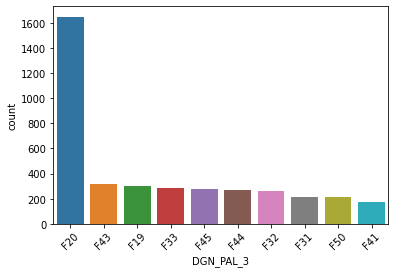

In [61]:
# On définit les n_top_diag diagnostics les plus fréquents souhaités
n_top_diag = 10
df_top_diag = df_mco_b[filtres_mco_b].DGN_PAL_3.value_counts().iloc[:n_top_diag].index

# On affiche les résultats sous forme d'histogramme
chart = sns.countplot(
    x="DGN_PAL_3",
    data=df_mco_b,
    order=df_top_diag   # On se limite aux n_top_diag
)

# On fait une rotation des labels sur l'axe des abscisses
labels = chart.set_xticklabels(chart.get_xticklabels() , rotation=45)

## Exercice 5 bis : Top diagnostics principaux de la sous-cohorte

Après avoir trouvé le top 10 (ou n) diagnostics de l'ensemble des patients, nous allons calculer les diagnostics les plus fréquents pour notre sous-cohorte de patientes, lors de leurs hospitalisations.

 Les diagnostics se trouvent dans la table **T_MCO_B**, que nous allons donc joindre à la table **T_MCO_C**  pour retrouver notre sous-cohorte. Le countplot permet de grouper les données par diagnostic, de compter les valeurs correspondantes et d'afficher le résultat.

<AxesSubplot:xlabel='DGN_PAL_3', ylabel='count'>

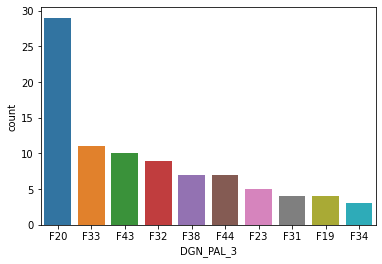

In [62]:
# On commence par joindre les tables MCO (dates de soins et description du séjour), afin
# d'associer les informations de séjour aux diagnostics correspondants.
# On ne regarde ici que les patients appartenants à la sous-cohorte.

df_mco_coh = df_mco_b[filtres_mco_b].join(df_mco_c[filtres_mco_c]).dropna()

# On définit les n_top_diag diagnostics les plus fréquents souhaités pour notre
# sous-cohorte de patientes, et pour les séjours sélectionnés
n_top_diag = 10
df_top_diag = df_mco_coh.DGN_PAL_3.value_counts().iloc[:n_top_diag].index

sns.countplot(
    x="DGN_PAL_3", 
    data=df_mco_coh, 
    order=df_top_diag    # On se limite aux n_top_diag
)